In [1]:
# prepare dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy

file = './10334-1.csv'

def prepare_data(filepath, 
                 dropdup = 1,
                 dropna = 1,
                 remove_outlier = 1,
                 standardize = 1):
    
    data = pd.read_csv('./10334-1.csv')
    data['age_group_start'] = [int(i[1]['age-group'][:2]) if i[1]['age-group'][1]!='-' else 5 for i in data.iterrows()]
    age = np.array(data.age_group_start).astype(float)

    data_mean = np.nan
    data_std = np.nan
    age
    # preprocess
    
    if dropdup: # select most recent record per patient
        data['date'] = pd.to_datetime(data.date)
        data = data.sort_values(by='date', ascending=True)
        data = data.drop_duplicates(subset='id', keep='last') # remove multiple patient records
    if dropna:
        data = data.dropna(inplace=False, subset='value')
    if remove_outlier:
        age = np.array(data.age_group_start).astype(float)
        data = np.array(data.value).astype(float)
        idx = (data >= np.quantile(data, 0.01)) & (data <= np.quantile(data, 0.99))
        age = age[idx]
        data = data[idx]
    if standardize:
        data_mean = data.mean()
        data_std = data.std()
        data = (data - data_mean)/data_std

    return data, data_mean, data_std, age

# # inspect
# plt.hist(data, 50, density=True);
# plt.ylabel('Density')
# plt.xlabel('Concentration (u/ml)')
# plt.title('Distribution of CA-125 concentrations');
# plt.grid();


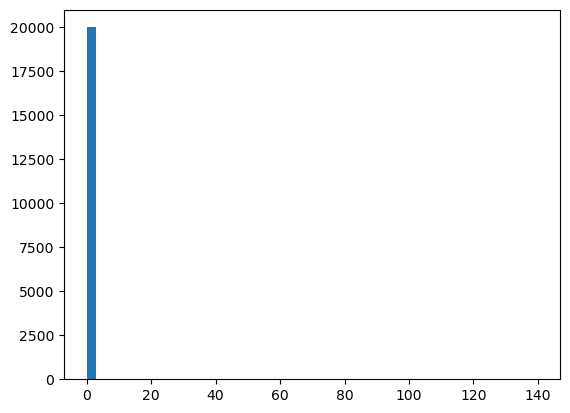

In [2]:
# check outliers
data, _, _, _ = prepare_data('./10334-1.csv', dropdup=1, dropna=1, remove_outlier=0, standardize=0)
data = data.value.values
data = (data-data.mean())/data.std()
import matplotlib.pyplot as plt
plt.hist(data, 50);


In [3]:
# official data for analysis
data, mn, std, age = prepare_data(file, standardize=0)

def bin_array(arr, bin_size):
    return np.floor_divide(arr, bin_size) * bin_size

age_bin_size = 20
binned_age = bin_array(age, age_bin_size).astype(int)


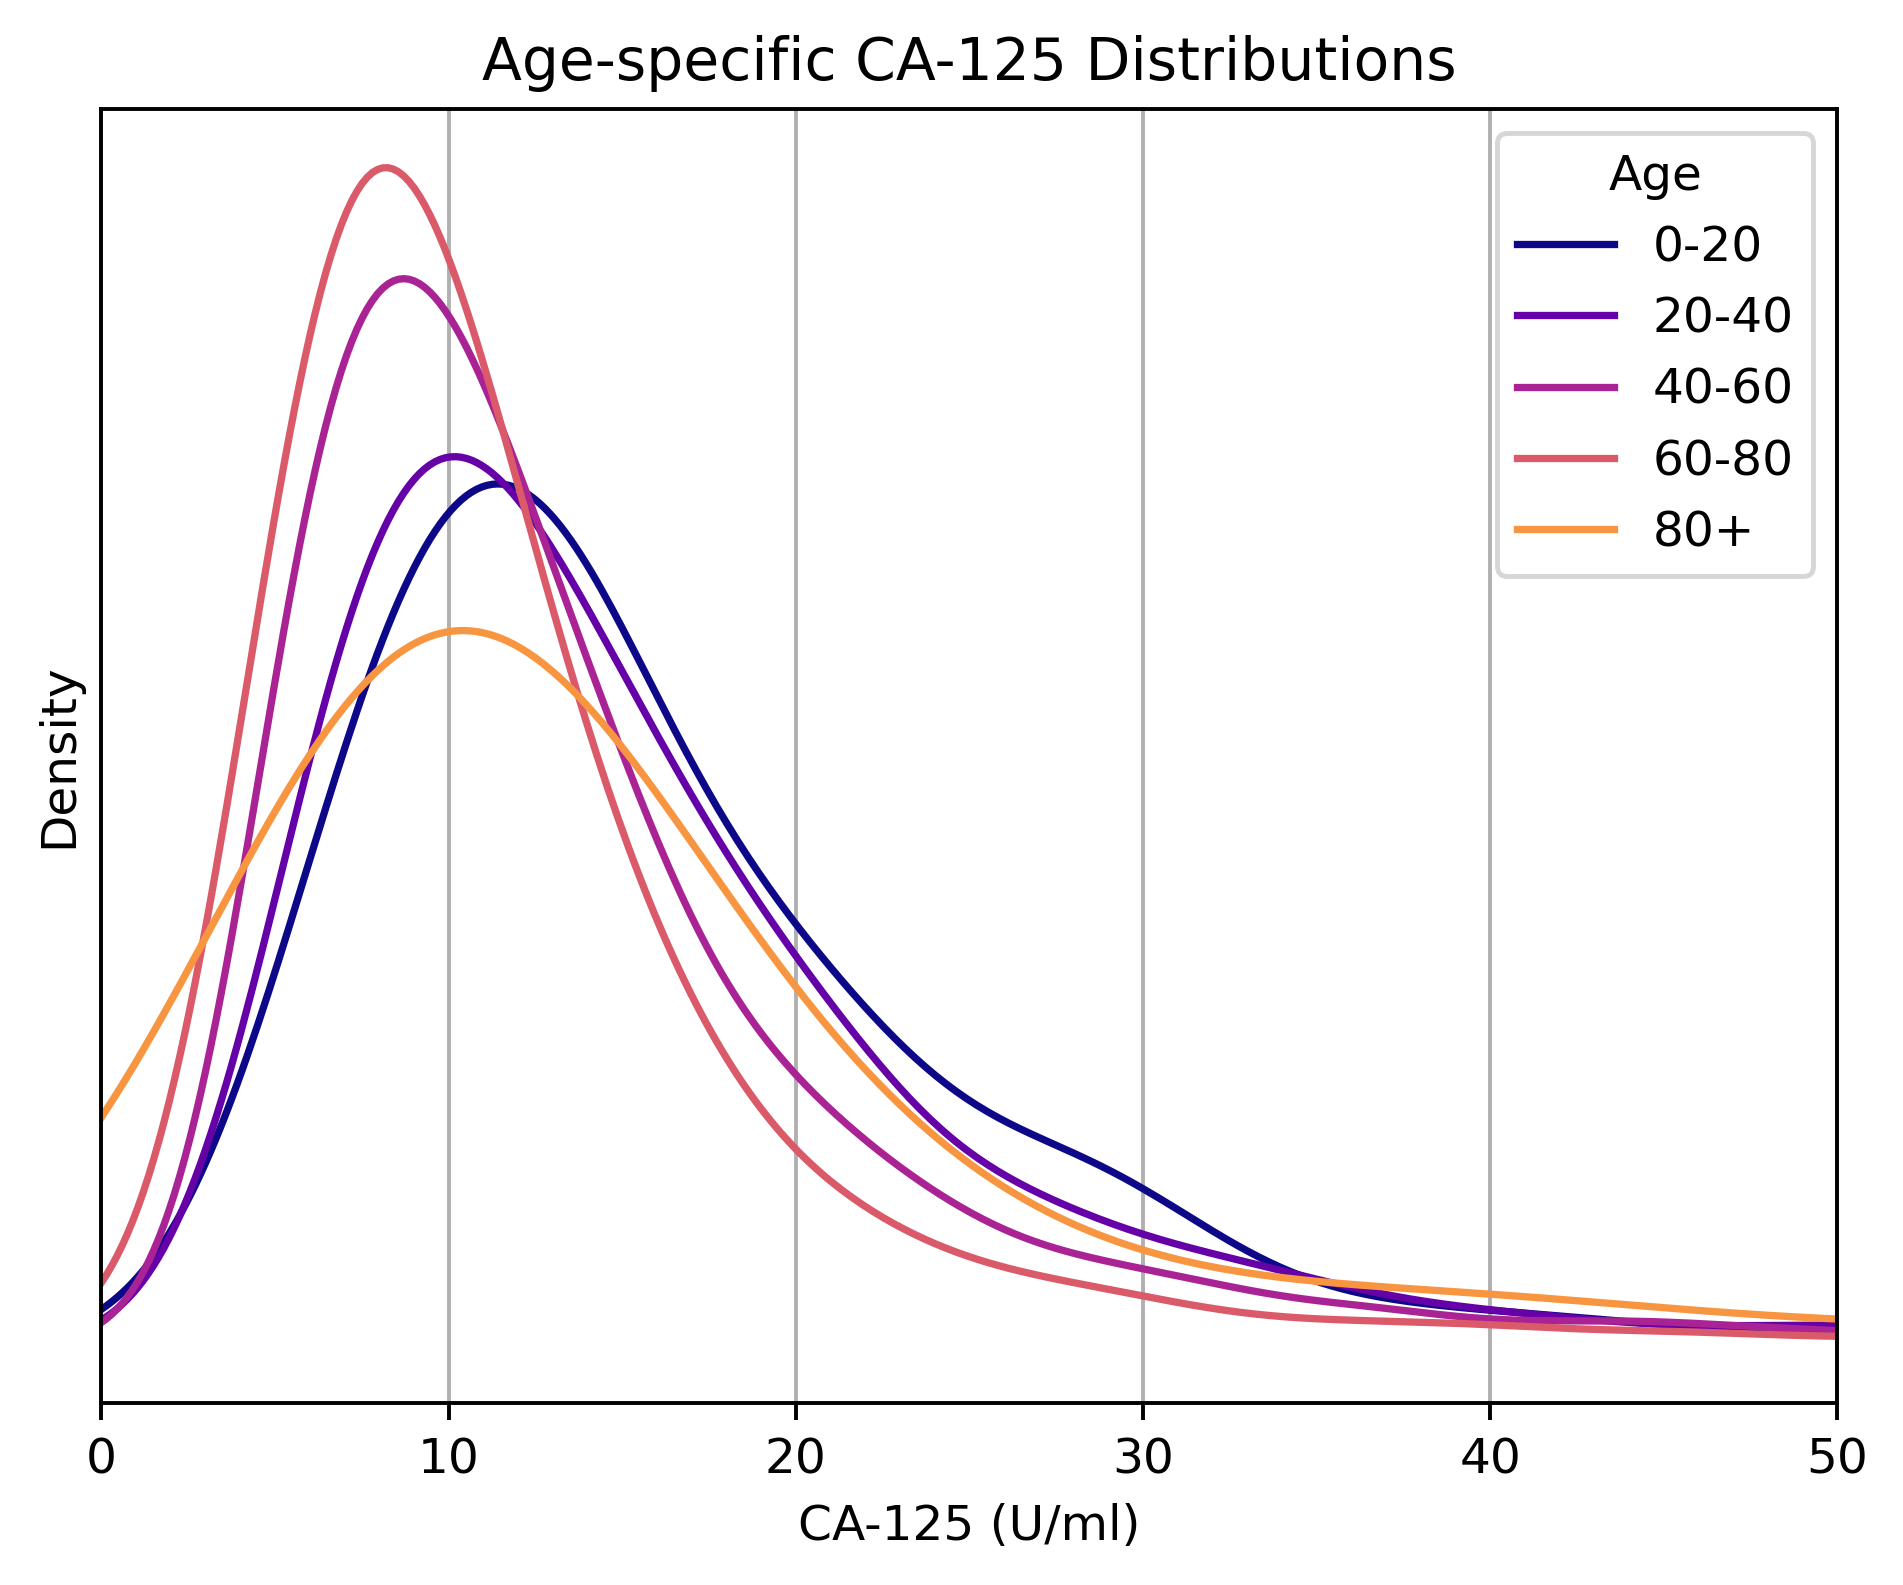

In [4]:
colormap = mpl.colormaps['plasma']  # Replace 'viridis' with the desired colormap
colors = colormap(np.linspace(0, 0.75, len(set(binned_age))))
# colors = colormap(np.linspace(0, 0.75, 4))

plt.figure(dpi=350)
for c,i in enumerate(sorted(list(set(binned_age)))):
    sample = data[binned_age==i]
    kde = scipy.stats.gaussian_kde(sample)
    x = np.linspace(0, 150, 1000)
    density = kde(x)
    total_area = np.trapz(density, dx=0.01)
    density /= total_area
    if i!=80:
        plt.plot(x, density, color=colors[c], alpha=1, label=str(i)+'-'+str(i+age_bin_size))
    else:
        plt.plot(x, density, color=colors[c], alpha=1, label=str(i)+'+')

plt.legend(title='Age');
plt.gcf().set_facecolor('white')
plt.grid();
plt.ylabel('Density')
plt.xlabel('CA-125 (U/ml)')
plt.xlim([0, 50]);
plt.gca().set_yticks([]);
plt.title('Age-specific CA-125 Distributions');


In [5]:
np.mean(data)


14.801592356687898

In [6]:
np.median(data)


11.4

In [7]:
np.quantile(data, 0.1)


5.824000000000001

In [8]:
np.quantile(data, 0.90)


25.6

In [9]:
max(data)


147.0

In [10]:
min(data)


3.2

In [11]:
# number of points per year
df = pd.read_csv('./10334-1.csv')
df = df.drop_duplicates(subset='id', keep='last') # remove multiple patient records
df = df.dropna(inplace=False, subset='value')
idx = np.where((df.value >= np.quantile(df.value, 0.01)) & (df.value <= np.quantile(df.value, 0.99)))[0]
df = df.iloc[idx]
for i in sorted(list(set(df.year))):
    print(i, '\t', len(df[df.year==i]))


2017 	 4
2018 	 13
2019 	 1458
2020 	 5193
2021 	 4242
2022 	 4726
2023 	 3989


In [12]:
# number of points per age group
df['age_group_start'] = [int(i[1]['age-group'][:2]) if i[1]['age-group'][1]!='-' else 5 for i in df.iterrows()]

def bin_array(arr, bin_size):
    return np.floor_divide(arr, bin_size) * bin_size

df['age_group_binned'] = bin_array(df.age_group_start, 20)

for i in sorted(list(set(df.age_group_binned))):
    print(i, '\t', len(df[df.age_group_binned==i]))


0 	 828
20 	 5724
40 	 8446
60 	 4063
80 	 564


In [13]:
scipy.__version__


'1.11.1'